In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from graphframes import GraphFrame
# Step 1: Set Up GraphFrames in PySpark
spark = SparkSession.builder \
    .appName("Provider-Patient Network") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.1-s_2.12") \
    .getOrCreate()
# Step 2: Load Data
claims = spark.read.csv("dbfs:/FileStore/tables/train_full.csv", header=True, inferSchema=True)
# Step 3: Create Vertices (Nodes)
# Patients as vertices
patients = claims.select("BeneID").distinct().withColumnRenamed("BeneID", "id").withColumn("type", lit("patient"))

# Providers as vertices
providers = claims.select("Provider").distinct().withColumnRenamed("Provider", "id").withColumn("type", lit("provider"))

# Union all vertices
vertices = patients.union(providers)

# Step 4: Create Edges (Connections: patient → provider)
edges = claims.selectExpr(
    "BeneID as src",
    "Provider as dst",
    "InscClaimAmtReimbursed",
    "ClaimStartDt",
    "ClaimEndDt",
    "PotentialFraud"
)
# Step 5: Build GraphFrame
g = GraphFrame(vertices, edges)



/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


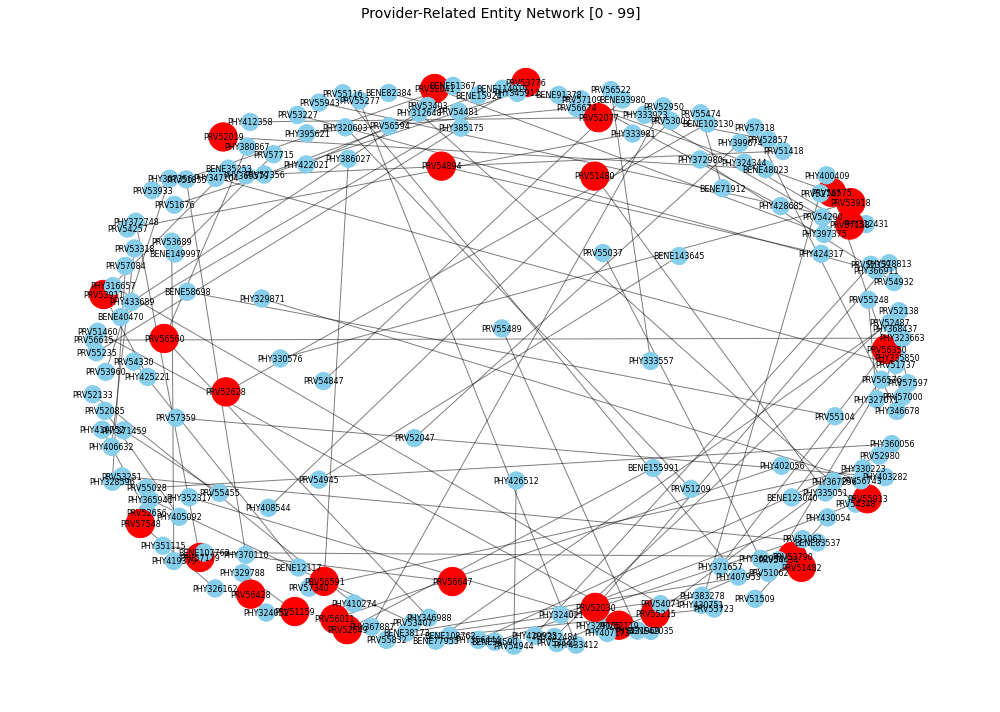

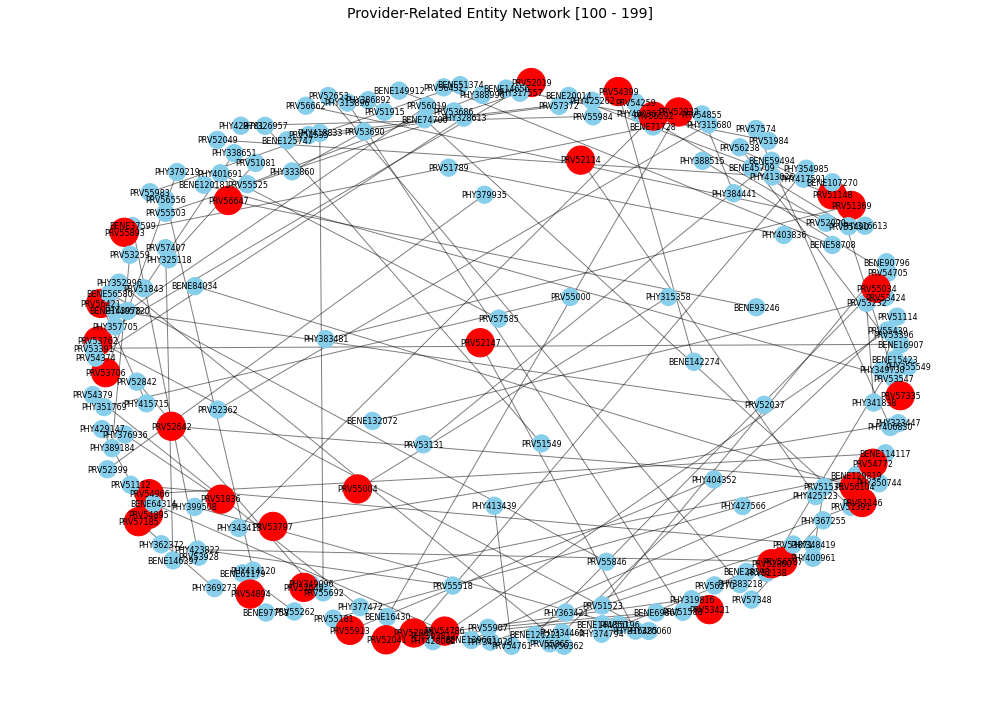

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Convert necessary columns to string and select only required columns
claims_filtered = claims.select(
    claims["Provider"].cast("string"),
    claims["BeneID"].cast("string"),
    claims["AttendingPhysician"].cast("string"),
    claims["OperatingPhysician"].cast("string"),
    claims["PotentialFraud"]
).dropna(how="any")  # drop rows with missing fields to avoid broken edges

# Identify fraudulent providers
fraud_ids = set(
    row['Provider'] for row in 
    claims_filtered.filter("PotentialFraud = 'Yes'").select("Provider").distinct().collect()
)

# Create edge list manually
edge_list = []

for row in claims_filtered.collect():
    provider = row['Provider']
    bene = row['BeneID']
    attend = row['AttendingPhysician']
    operate = row['OperatingPhysician']
    
    if bene:
        edge_list.append((provider, bene, "treats_patient"))
    if attend:
        edge_list.append((provider, attend, "attended_by"))
    if operate:
        edge_list.append((provider, operate, "operated_by"))

# Convert to pandas DataFrame
edges_df = pd.DataFrame(edge_list, columns=['src', 'dst', 'relationship'])

# Shuffle the edges
edges_df = edges_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Limit to 100 edges for 2 typical graphs
edges_per_graph = 100
total_edges = min(len(edges_df), edges_per_graph * 2)
edges_df = edges_df.iloc[:total_edges]

# Draw 2 subgraphs, each with 100 edges
for i in range(2):
    start_idx = i * edges_per_graph
    end_idx = min((i + 1) * edges_per_graph, total_edges)
    subset_edges = edges_df.iloc[start_idx:end_idx]

    G = nx.from_pandas_edgelist(subset_edges, source='src', target='dst', edge_attr='relationship')

    nodes_str = list(G.nodes())
    color_map = ['red' if node in fraud_ids else 'skyblue' for node in nodes_str]
    size_map = [800 if node in fraud_ids else 300 for node in nodes_str]

    pos = nx.spring_layout(G, seed=42, k=1)

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=size_map)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1.0)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Provider-Related Entity Network [{start_idx} - {end_idx - 1}]", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


**Explaination:**

This code builds and visualizes a healthcare network graph based on claims data, showing **connections** between **providers, patients, and physicians**. It highlights providers flagged as potentially fraudulent by coloring their nodes **red** and making them larger. Only the first 200 edges are used to generate two visual subgraphs for clearer interpretation. The visualization helps identify unusual patterns or dense connections around fraudulent providers, which may suggest suspicious behavior.

I used nx.spring_layout(G), which is a force-directed layout algorithm. The distances between nodes in this layout are **not literal or geographical**. Instead, they reflect **how strongly connected the nodes are** based on the network structure.

Specifically:
1. Nodes that are **more connected to each other tend to appear closer together**.
2. Nodes that share many edges (direct or indirect) will be pulled closer by virtual "springs".
3. Nodes that are **less connected or disconnected** will be **pushed farther apart**.

The layout is designed to visually highlight clusters or tightly linked groups in the graph.
So the closer two nodes are, the more strongly they are connected in the graph structure, but not represent real-world distances like time, geography.  

In addition, **the clustering of red provider nodes** likely indicates **potential fraud rings or collusion**. These providers may be frequently connected through shared patients or physicians, forming dense subgraphs. Such structural patterns can suggest coordinated fraudulent activity. Visual clustering can thus help investigators **prioritize** high-risk entities for further analysis.